ver: 20201016.1257

In [1]:
# Initialization for this notebook.

import numpy as np
import matplotlib.pyplot as plt

# Un-comment the following line to use interactive matplotlib widget.
#%matplotlib widget

# Returns a n seqence based on the offset provided.
seq_n = lambda seq, noff: np.arange(seq.size) - noff

# Pretty print a sequence.
seq_print = lambda seq, noff, name: print('noff_%s =%2d, %s =' % (name, noff, name), seq.astype(float))

# Common sequence generators.
seq_delta = lambda n_min, n_max: (np.array([ 1 if n==0 else 0 for n in range(n_min, n_max+1)]), 0 - n_min)
seq_u = lambda n_min, n_max: (np.array([ 0 if n<0 else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_R_N = lambda N, n_min, n_max: (np.array([ 0 if (n<0 or n>=N) else 1 for n in range(n_min, n_max+1)]), 0-n_min)
seq_real_exp = lambda a, n_min, n_max: (np.array([ 0 if n<0 else a**n for n in range(n_min, n_max+1)]), 0-n_min)
seq_complex_exp = lambda sigma, omega_0, n_min, n_max: (np.array([ np.exp((sigma + 1j*omega_0)*n) for n in range(n_min, n_max+1)]), 0-n_min)
seq_sin = lambda A, omega_0, phi, n_min, n_max: (np.array([ A*np.sin(omega_0*n + phi) for n in range(n_min, n_max+1)]), 0-n_min)

编程实现以下常系数线性差分方程所代表的系统：
$$ y(n) - y(n-1) = x(n) $$

将原常系数线性差分方程整理为：
$$ y(n) = x(n) + y(n-1) $$

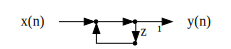

In [2]:
# Show the system block diagram.
from IPython.core.display import SVG
SVG(filename='1.3-fig-1.17.dot.svg')

## 经典的实现方法

In [3]:
def T(x):
    # [BEST PRACTICE] Allocate enough space before using an array.
    y = np.zeros(x.size)
    
    # Compute output values one-by-one.
    # [NOTICE] During most LSI DSP, n's true value is not important (the relative value is, however). It is the user's responsibility to take care of it before and after DSP.
    for n in range(x.size):
        if n==0:
            # There is no y[n-1]=y[0-1]=y[-1] provided, so here we assume the system is causal, so y[-1]=0.
            # [NOTICE] The developer has to consider carefully if the assumption is reasonable. If in doubt, let the user decide by adding more arguments to this function, e.g. T(x, y_init), where y_init means the initial condition of y (i.e. y[-1] here).
            y[n] = x[n]
        else:
            y[n] = x[n] + y[n-1]
    return y

单元测试1：输入 $ \delta(n) $，预期输出为 $ u(n) $

In [4]:
# Define input sequence.
(n_min, n_max) = (-5, 5)
(x, noff_x) = seq_delta(n_min, n_max)
seq_print(x, noff_x, 'x')

# Compute output sequence.
(y, noff_y) = (T(x), noff_x)
seq_print(y, noff_y, 'y')

noff_x = 5, x = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
noff_y = 5, y = [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


单元测试2：输入 $ u(n) $，预期输出为 $ (n+1)u(n) $

In [5]:
# Define input sequence.
(n_min, n_max) = (-5, 5)
(x, noff_x) = seq_u(n_min, n_max)
seq_print(x, noff_x, 'x')

# Compute output sequence.
(y, noff_y) = (T(x), noff_x)
seq_print(y, noff_y, 'y')

noff_x = 5, x = [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
noff_y = 5, y = [0. 0. 0. 0. 0. 1. 2. 3. 4. 5. 6.]


单元测试3：输入 $ R_3(n) $，预期输出为 $ [\underline{1}, 2, 3] + 3*u(n-3) $

In [6]:
# Define input sequence.
(n_min, n_max) = (-5, 5)
(x, noff_x) = seq_R_N(3, n_min, n_max)
seq_print(x, noff_x, 'x')

# Compute output sequence.
(y, noff_y) = (T(x), noff_x)
seq_print(y, noff_y, 'y')

noff_x = 5, x = [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
noff_y = 5, y = [0. 0. 0. 0. 0. 1. 2. 3. 3. 3. 3.]


## 基于数据流的实现方法

In [7]:
class T_stream:
    """A class to process input stream, i.e. one value at a time."""

    # A storage to keep y[n-1], assuming causal system.
    y_z1 = 0

    def process(self, x):
        """Process one single input value x[n] and return y[n]."""

        # y[n] = x[n] + y[n-1]
        y = x + self.y_z1

        # Store the y[n], so that when process() is called next time, it will be y[n-1]
        self.y_z1 = y

        return y

单元测试：输入 $ R_3(n) $，预期输出为 $ [\underline{1}, 2, 3] + 3*u(n) $

In [8]:
# Define input sequence.
(n_min, n_max) = (-5, 5)
(x, noff_x) = seq_R_N(3, n_min, n_max)
seq_print(x, noff_x, 'x')

# Create a T_stream object.
t_stream = T_stream()

# Process the input sequence one value at a time.
(y, noff_y) = (np.array([t_stream.process(x_i) for x_i in x]), noff_x)
seq_print(y, noff_y, 'y')

noff_x = 5, x = [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
noff_y = 5, y = [0. 0. 0. 0. 0. 1. 2. 3. 3. 3. 3.]


### 核心思想

- 将计算缩小到最小单元，即只完成当前时刻$n$的计算：只输入一个值$x(n)$，只计算一个输出值$y(n)$。
- 完成当前时刻$n$的计算后，将下一个时刻$n+1$的计算中所需要的数值保存下来
  - 例如这个系统中，需要保存当前的$y(n)$，作为下一个时刻计算所需的“$y(n-1)$”。

### 优点

- 计算模块本身所需存储空间小：不需要存储整个输入和输出序列。
- 适合任意长的信号处理：分段处理非常容易实现。

假设输入序列 $x(n)$ 是分成多段逐段接收到的，如果系统采用“经典”的实现方法，而又未作任何辅助处理，结果很有可能是错的。

In [9]:
x_total_len = 0

print('Receiving x (part 1)...')
(x, noff_x) = (np.array([0, 0, 0, 0, 1, 1, 1, 0]), 0)
seq_print(x, noff_x, 'x')
(y, noff_y) = (T(x), noff_x)
seq_print(y, noff_y, 'y')
x_total_len = x_total_len + x.size
print('x_total_len =', x_total_len, '\n')

print('Receiving x (part 2)...')
(x, noff_x) = (np.array([0, 0, 0, 0, 0, 0, 0, 0]), -x_total_len)
seq_print(x, noff_x, 'x')
(y, noff_y) = (T(x), noff_x)
seq_print(y, noff_y, 'y')
x_total_len = x_total_len + x.size
print('x_total_len =', x_total_len, '\n')

# Can you spot the problem in the second part?

Receiving x (part 1)...
noff_x = 0, x = [0. 0. 0. 0. 1. 1. 1. 0.]
noff_y = 0, y = [0. 0. 0. 0. 1. 2. 3. 3.]
x_total_len = 8 

Receiving x (part 2)...
noff_x =-8, x = [0. 0. 0. 0. 0. 0. 0. 0.]
noff_y =-8, y = [0. 0. 0. 0. 0. 0. 0. 0.]
x_total_len = 16 



要纠正上面的错误，一种方法是把输入序列的所有段都缓存并拼接起来，再一次过输入系统得出完整的输出。可是这样不但耗费存储空间，也大大增加处理的时延。而更简单有效的方法，是采用“基于数据流”的实现。

In [10]:
x_total_len = 0
t_stream = T_stream()

print('Receiving x (part 1)...')
(x, noff_x) = (np.array([0, 0, 0, 0, 1, 1, 1, 0]), 0)
seq_print(x, noff_x, 'x')
(y, noff_y) = (np.array([t_stream.process(x_i) for x_i in x]), noff_x)
seq_print(y, noff_y, 'y')
x_total_len = x_total_len + x.size
print('x_total_len =', x_total_len, '\n')

print('Receiving x (part 2)...')
(x, noff_x) = (np.array([0, 0, 0, 0, 0, 0, 0, 0]), -x_total_len)
seq_print(x, noff_x, 'x')
(y, noff_y) = (np.array([t_stream.process(x_i) for x_i in x]), noff_x)
seq_print(y, noff_y, 'y')
x_total_len = x_total_len + x.size
print('x_total_len =', x_total_len, '\n')


Receiving x (part 1)...
noff_x = 0, x = [0. 0. 0. 0. 1. 1. 1. 0.]
noff_y = 0, y = [0. 0. 0. 0. 1. 2. 3. 3.]
x_total_len = 8 

Receiving x (part 2)...
noff_x =-8, x = [0. 0. 0. 0. 0. 0. 0. 0.]
noff_y =-8, y = [3. 3. 3. 3. 3. 3. 3. 3.]
x_total_len = 16 

